In [1]:
!pip install --upgrade pip
!pip install jax[tpu] -f https://storage.googleapis.com/jax-releases/libtpu_releases.html
# !pip install jax
!pip install jaxlib diffusers huggingface_hub flax transformers
!pip install orbax-checkpoint
!pip install -U huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.2 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Looking in links: https://storage.googleapis.com/jax-releases/libtpu_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.2/346.2 kB 6.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
from diffusers import FlaxUNet2DConditionModel
from IPython.display import clear_output

loaded_model = FlaxUNet2DConditionModel.from_pretrained('ekhalavyan/sdxl-unet')
clear_output(wait=False) # Clear the loading messages
unet_module = loaded_model[0] # Extract the Flax Module
# unet_variables = {'params': diff_unet[1]} # Extract the parameters

# print(unet_variables.keys())
unet_module

FlaxUNet2DConditionModel(
    # attributes
    sample_size = 128
    in_channels = 4
    out_channels = 4
    down_block_types = ['DownBlock2D', 'CrossAttnDownBlock2D', 'CrossAttnDownBlock2D']
    up_block_types = ['CrossAttnUpBlock2D', 'CrossAttnUpBlock2D', 'UpBlock2D']
    only_cross_attention = False
    block_out_channels = [320, 640, 1280]
    layers_per_block = 2
    attention_head_dim = [5, 10, 20]
    num_attention_heads = None
    cross_attention_dim = 2048
    dropout = 0.0
    use_linear_projection = True
    dtype = float32
    flip_sin_to_cos = True
    freq_shift = 0
    use_memory_efficient_attention = False
    split_head_dim = False
    transformer_layers_per_block = [1, 2, 10]
    addition_embed_type = 'text_time'
    addition_time_embed_dim = 256
    addition_embed_type_num_heads = 64
    projection_class_embeddings_input_dim = 2816
)

In [3]:
import jax
import numpy as np
import jax.numpy as jnp
import orbax.checkpoint

from pathlib import Path
from jax import pmap
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt
from typing import Dict, List, Optional, Union
import requests
from io import BytesIO

from diffusers.utils import PIL_INTERPOLATION

from huggingface_hub import notebook_login
from diffusers import FlaxStableDiffusionPipeline
import transformers
import time
from diffusers.utils import make_image_grid
from huggingface_hub import hf_hub_download

In [4]:
from typing import Dict, List, Optional, Union
import requests
from io import BytesIO
from diffusers.utils import PIL_INTERPOLATION

In [5]:
sdxl_params = {}
dtype = jnp.bfloat16

In [6]:
sdxl_params['unet'] = {'params': jax.tree_util.tree_map(lambda x: x.astype(dtype), loaded_model[1])}

In [7]:
from transformers import CLIPTokenizer
tokenizer_1 = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
tokenizer_2 = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')

In [8]:
from transformers import FlaxCLIPTextModel, FlaxCLIPTextModelWithProjection
text_encoder_1 = FlaxCLIPTextModel.from_pretrained('/kaggle/input/sdxl-text-encoder-1')
text_encoder_2 = FlaxCLIPTextModelWithProjection.from_pretrained('/kaggle/input/text-encoder-2')

In [9]:
sdxl_params['text_encoder_1'] = {'params': jax.tree_util.tree_map(lambda x: x.astype(dtype), text_encoder_1.params)}
sdxl_params['text_encoder_2'] = {'params': jax.tree_util.tree_map(lambda x: x.astype(dtype), text_encoder_2.params)}

In [10]:
from diffusers import FlaxAutoencoderKL
from IPython.display import clear_output

loaded_model = FlaxAutoencoderKL.from_pretrained('ekhalavyan/sdxl-vae')
clear_output(wait=False) # Clear the loading messages
vae_module = loaded_model[0] # Extract the Flax Module
# vae_variables = {'params': diff_vae[1]} # Extract the parameters

sdxl_params['vae'] = {'params': jax.tree_util.tree_map(lambda x: x.astype(dtype), loaded_model[1])}

# print(vae_variables.keys())
vae_module

FlaxAutoencoderKL(
    # attributes
    in_channels = 3
    out_channels = 3
    down_block_types = ['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D']
    up_block_types = ['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D']
    block_out_channels = [128, 256, 512, 512]
    layers_per_block = 2
    act_fn = 'silu'
    latent_channels = 4
    norm_num_groups = 32
    sample_size = 1024
    scaling_factor = 0.13025
    dtype = float32
)

In [11]:
from diffusers import FlaxEulerDiscreteScheduler
loaded_model = FlaxEulerDiscreteScheduler.from_pretrained('/kaggle/input/sdxl-scheduler/config.json')
scheduler_module = loaded_model[0]
scheduler_params = loaded_model[1]
sdxl_params['scheduler'] = {'params': loaded_model[1]}

In [12]:
loaded_model = 5

In [13]:
vae_scale_factor = 2 ** (len(vae_module.config.block_out_channels) - 1)
height = unet_module.config.sample_size * vae_scale_factor
width = unet_module.config.sample_size * vae_scale_factor

In [14]:
unet_module.config.sample_size * vae_scale_factor //2

512

In [15]:
guidance_scale = 5.0
num_steps = 50
default_seed = 33
strength = 0.01

In [16]:
def get_timestep_start(num_inference_steps, strength):
    # get the original timestep using init_timestep
    init_timestep = min(int(num_inference_steps * strength), num_inference_steps)

    t_start = max(num_inference_steps - init_timestep, 0)

    return t_start

In [17]:
start_timestep = get_timestep_start(num_steps, strength)

# latents_shape = (
#             1,
#             unet_module.config.in_channels,
#             height // vae_scale_factor,
#             width // vae_scale_factor
# )
start_timestep

50

In [18]:
# @jax.jit
@partial(
    jax.pmap,
    in_axes=(0, 0, 0, 0, 0, None, None, 0),
    static_broadcasted_argnums=(5, 6),
)
def generate_img2img(
    sdxl_params,
    image,
    positive_input_ids,
    negative_input_ids=None,
    prng_seed=jax.random.PRNGKey(42),
    guidance_scale=5.0,
    num_inference_steps=50,
    noise: Optional[jnp.ndarray] = None,
):
    print(positive_input_ids.shape)
    
    def get_embeddings(prompt_ids):
        print(prompt_ids.shape)
        te_1_inputs = prompt_ids[:, 0, :]
        te_2_inputs = prompt_ids[:, 1, :]
        
        print(te_1_inputs.shape, te_2_inputs.shape)
        print("sdxl_params:", sdxl_params['text_encoder_1']['params']['text_model']['embeddings']['position_embedding']['embedding'].shape)
        
        prompt_embeds_1 = text_encoder_1(te_1_inputs,params=sdxl_params['text_encoder_1']['params'], output_hidden_states=True)["hidden_states"][-2]
        prompt_embeds_2 = text_encoder_2(te_2_inputs,params=sdxl_params['text_encoder_2']['params'], output_hidden_states=True)["hidden_states"][-2]

        prompt_embeds = jnp.concatenate([prompt_embeds_1, prompt_embeds_2], axis=-1)
        pooled_embeds = text_encoder_2(te_2_inputs,params=sdxl_params['text_encoder_2']['params'], output_hidden_states=True)["text_embeds"]
        
        return prompt_embeds, pooled_embeds
    
    positive_prompt_embeds, positive_pooled_embeds = get_embeddings(positive_input_ids)
    batch_size = positive_prompt_embeds.shape[0]
    
    if negative_input_ids is None:
        negative_prompt_embeds = jnp.zeros_like(positive_prompt_embeds)
        negative_pooled_embeds = jnp.zeros_like(positive_pooled_embeds)
    else:       
        negative_prompt_embeds, negative_pooled_embeds = get_embeddings(negative_input_ids)
        
    prompt_embeds = jnp.concatenate([negative_prompt_embeds, positive_prompt_embeds], axis=0)  # (2, 77, 2048)
#     print(prompt_embeds.shape)
    guidance_scale = jnp.array([guidance_scale], dtype=jnp.float32)
    latents_shape = (
                batch_size,
                unet_module.config.in_channels,
                height // vae_scale_factor,
                width // vae_scale_factor,
            )
    
    print("latents_shape: ", latents_shape, "batch_size: ", batch_size)
    
    if noise is None:
        noise = jax.random.normal(prng_seed, shape=latents_shape, dtype=jnp.float32)
    else:
        if noise.shape != latents_shape:
            raise ValueError(f"Unexpected latents shape, got {noise.shape}, expected {latents_shape}")
            
    # Create init_latents
    init_latent_dist = vae_module.apply(sdxl_params['vae'], image, method=vae_module.encode).latent_dist
#     print("init_latent_dist: ", init_latent_dist.shape)
    init_latents = init_latent_dist.sample(key=prng_seed).transpose((0, 3, 1, 2))
    print("init_latents: ", init_latents.shape)

    init_latents = vae_module.config.get("scaling_factor") * init_latents
        
    def _get_add_time_ids(original_size, crops_coords_top_left, target_size, bs, dtype):
        add_time_ids = list(original_size + crops_coords_top_left + target_size)
        add_time_ids = jnp.array([add_time_ids] * bs, dtype=dtype)
        return add_time_ids
    
    add_time_ids = _get_add_time_ids(
        (height, width), (0, 0), (height, width), positive_prompt_embeds.shape[0], dtype=positive_prompt_embeds.dtype
    )
    
    add_text_embeds = jnp.concatenate([negative_pooled_embeds, positive_pooled_embeds], axis=0)
    add_time_ids = jnp.concatenate([add_time_ids, add_time_ids], axis=0)
    
    added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}
    
    def loop_body(step, args):
        latents, scheduler_state = args
        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        latents_input = jnp.concatenate([latents] * 2)

        t = jnp.array(scheduler_state.timesteps, dtype=jnp.int32)[step]
        timestep = jnp.broadcast_to(t, latents_input.shape[0])

        latents_input = scheduler_module.scale_model_input(scheduler_state, latents_input, t)

        # predict the noise residual
        noise_pred = unet_module.apply(
            sdxl_params['unet'],
            jnp.array(latents_input),
            jnp.array(timestep, dtype=jnp.int32),
            encoder_hidden_states=prompt_embeds,
            added_cond_kwargs=added_cond_kwargs,
        ).sample
        # perform guidance
        noise_pred_uncond, noise_prediction_text = jnp.split(noise_pred, 2, axis=0)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents, scheduler_state = scheduler_module.step(scheduler_state, noise_pred, t, latents).to_tuple()
        return latents, scheduler_state
    
    scheduler_state = scheduler_module.set_timesteps(
        sdxl_params['scheduler']['params'], num_inference_steps=num_inference_steps, shape=latents_shape
    )
    
    print("scheduler_state.timesteps: ", scheduler_state.timesteps)
    
    if start_timestep == num_inference_steps:
        latent_timestep = scheduler_state.timesteps[-1].repeat(batch_size).astype(int)
        
    else:
        latent_timestep = scheduler_state.timesteps[start_timestep : start_timestep + 1].repeat(batch_size).astype(int)


    print("latents shape: ", init_latents.shape, "noise shape: ", noise.shape, "latent time step:, ", type(latent_timestep), latent_timestep, start_timestep)

    
    latents = scheduler_module.add_noise(sdxl_params['scheduler']['params'], init_latents, noise, latent_timestep)
    
    latents = latents * scheduler_state.init_noise_sigma

#     # scale the initial noise by the standard deviation required by the scheduler
#     latents = jax.random.normal(prng_seed, shape=latents_shape, dtype=jnp.float32) * scheduler_state.init_noise_sigma
    
    latents, _ = jax.lax.fori_loop(start_timestep, num_inference_steps, loop_body, (latents, scheduler_state))
    latents = 1 / vae_module.config.get("scaling_factor") * latents
    
    image = vae_module.apply(sdxl_params['vae'], latents, method=vae_module.decode).sample
    image = (image / 2 + 0.5).clip(0, 1).transpose(0, 2, 3, 1)
    image = (image * 255).round().astype("uint8")
    return image    

In [19]:
def tokenise_prompts(prompt):
    inputs = []
    for tokenizer in [tokenizer_1, tokenizer_2]:
        text_inputs = tokenizer(
            positive_prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
        inputs.append(text_inputs.input_ids)
    return jnp.stack(inputs, axis=1)

# def tokenise_prompts(prompt):
#     text_inputs = tokenizer_1(
#         positive_prompt,
#         padding="max_length",
#         max_length=tokenizer_1.model_max_length,
#         truncation=True,
#         return_tensors="np",
#     )
#     return text_inputs.input_ids

In [20]:
def preprocess(image, dtype):
    w, h = image.size
    if w>h:
        image = image.crop((0,0,h,h))
    else:
        image = image.crop((0,0,w,w))        
#     print(w,h)
#     w, h = (x - x % 32 for x in (h, h))  # resize to integer multiple of 32
    image = image.resize((1024, 1024), resample=PIL_INTERPOLATION["lanczos"])
    image = jnp.array(image).astype(dtype) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    return 2.0 * image - 1.0

(1, 3, 1024, 1024)


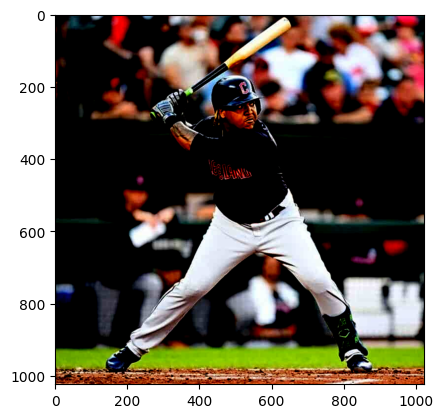

In [21]:
url = "https://www.baseballbible.net/wp-content/uploads/What-Is-a-Pull-Hitter-in-Baseball.jpg"
response = requests.get(url)
processed_images = preprocess(Image.open(BytesIO(response.content)).convert("RGB"), jnp.float32)
print(processed_images.shape)
plt.imshow(processed_images[0].transpose(1,2,0))

(8, 1, 2, 77)
Start Compiling
(1, 2, 77)
(1, 2, 77)
(1, 77) (1, 77)
sdxl_params: (77, 768)
latents_shape:  (1, 4, 128, 128) batch_size:  1
init_latents:  (1, 4, 128, 128)
scheduler_state.timesteps:  Traced<ShapedArray(float32[50])>with<DynamicJaxprTrace(level=0/1)>
latents shape:  (1, 4, 128, 128) noise shape:  (1, 4, 128, 128) latent time step:,  <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'> Traced<ShapedArray(int32[1])>with<DynamicJaxprTrace(level=0/1)> 50
Compiled in 40.16646480560303


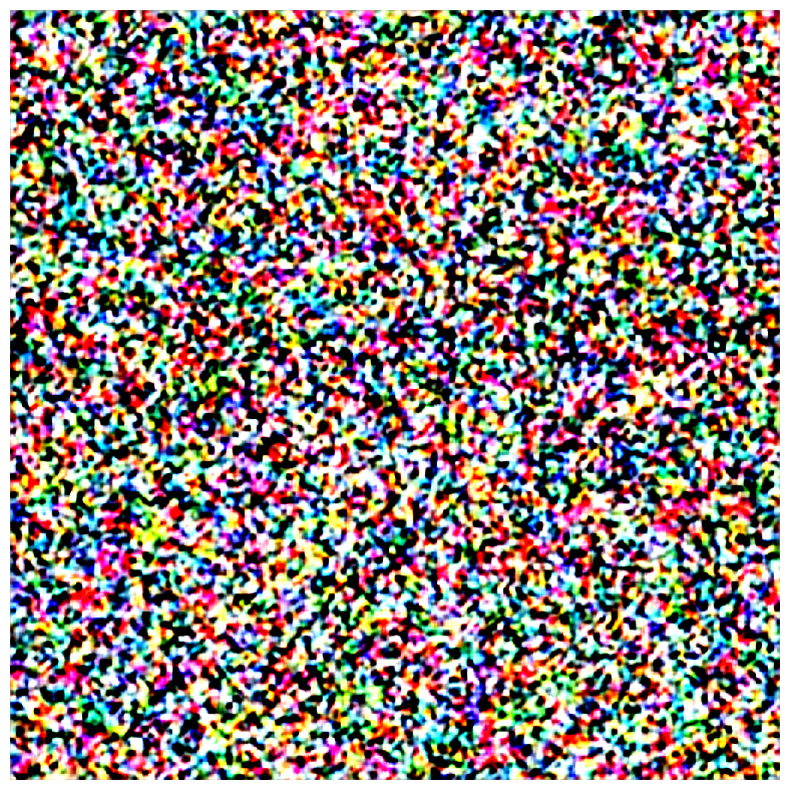

In [22]:
positive_prompt = '''Boy dressed in g hitting with a baseball bat. Realistic. portrait, 80mm lens, shallow depth of field, 
close up, split lighting, cinematic'''
negative_prompt = None
prng_seed = replicate(jax.random.PRNGKey(default_seed))
positive_input_ids = replicate(tokenise_prompts(positive_prompt))
sdxl_params = replicate(sdxl_params)
p_processed_image = replicate(processed_images)

#print("sdxl_params:", sdxl_params['text_encoder_1']['params']['text_model']['embeddings']['position_embedding']['embedding'].shape)

# prng_seed = jax.random.PRNGKey(default_seed)
# positive_input_ids = tokenise_prompts(positive_prompt)
print(positive_input_ids.shape)

print("Start Compiling")
start = time.time()
gen_image = generate_img2img(sdxl_params, p_processed_image, positive_input_ids, negative_prompt, prng_seed, guidance_scale, num_steps, noise = None)
print(f"Compiled in {time.time() - start}")
figsize=(10,10)
plt.figure(figsize=figsize)
plt.axis('off')
# plt.imshow(gen_image.reshape(gen_image.shape[1],gen_image.shape[2],gen_image.shape[3]))
plt.imshow(gen_image[0][0]) #.reshape(gen_image.shape[1],gen_image.shape[2],gen_image.shape[3]))

In [23]:
positive_prompt = '''Boy dressed in yellow hitting with a black baseball bat. Realistic. portrait, 80mm lens, shallow depth of field, 
close up, split lighting, cinematic'''
positive_input_ids = replicate(tokenise_prompts(positive_prompt))

Start Compiling
Compiled in 0.01572728157043457


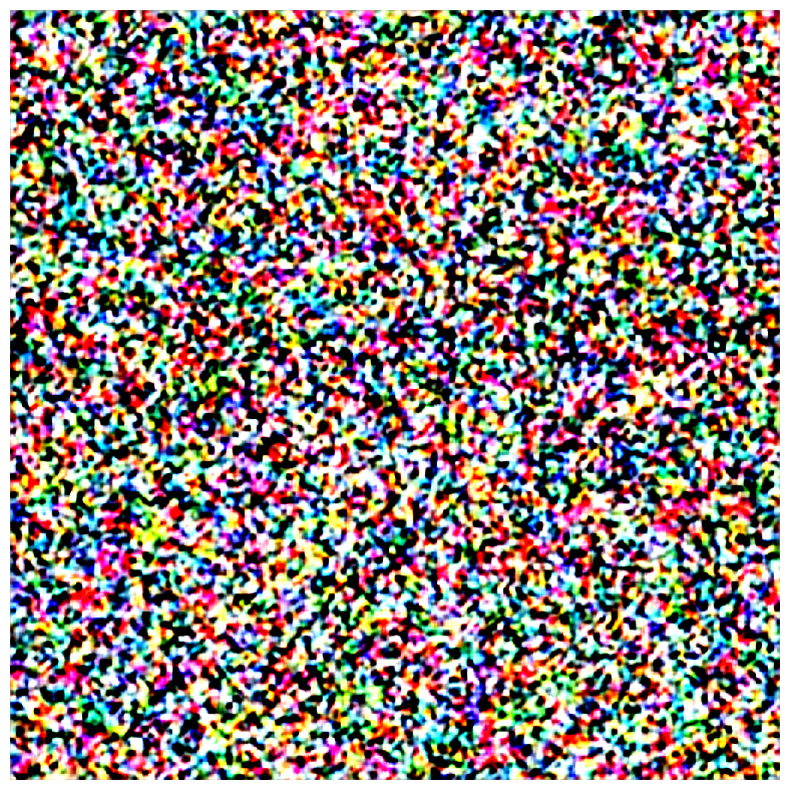

In [24]:
print("Start Compiling")
start = time.time()
gen_image = generate_img2img(sdxl_params, p_processed_image, positive_input_ids, negative_prompt, prng_seed, guidance_scale, num_steps, noise = None)
print(f"Compiled in {time.time() - start}")
figsize=(10,10)
plt.figure(figsize=figsize)
plt.axis('off')
# plt.imshow(gen_image.reshape(gen_image.shape[1],gen_image.shape[2],gen_image.shape[3]))
plt.imshow(gen_image[0][0]) #.reshape(gen_image.shape[1],gen_image.shape[2],gen_image.shape[3]))

In [25]:
from diffusers.schedulers.scheduling_utils_flax import broadcast_to_shape_from_left
scheduler_state = scheduler_module.set_timesteps(
        scheduler_params, num_inference_steps=num_steps, shape=(1,4,128,128)
)
noise = jax.random.normal(jax.random.PRNGKey(42), shape=(1,4,128,128), dtype=jnp.float32)
timez = scheduler_state.timesteps[50].repeat(1).astype(int)
sigma = broadcast_to_shape_from_left(scheduler_params.sigmas[timez].flatten(), (1,4,128,128))
sigma
# noisy_sample = jax.random.normal(jax.random.PRNGKey(42), shape=(1,4,128,128), dtype=jnp.float32)*(1+sigma)
# noisy_sample.min(),noisy_sample.max()

# noisy_sample = scheduler_module.add_noise(scheduler_params,noise,noise,timez)
# noisy_sample *= scheduler_params.init_noise_sigma

Array([[[[14.52627, 14.52627, 14.52627, ..., 14.52627, 14.52627,
          14.52627],
         [14.52627, 14.52627, 14.52627, ..., 14.52627, 14.52627,
          14.52627],
         [14.52627, 14.52627, 14.52627, ..., 14.52627, 14.52627,
          14.52627],
         ...,
         [14.52627, 14.52627, 14.52627, ..., 14.52627, 14.52627,
          14.52627],
         [14.52627, 14.52627, 14.52627, ..., 14.52627, 14.52627,
          14.52627],
         [14.52627, 14.52627, 14.52627, ..., 14.52627, 14.52627,
          14.52627]],

        [[14.52627, 14.52627, 14.52627, ..., 14.52627, 14.52627,
          14.52627],
         [14.52627, 14.52627, 14.52627, ..., 14.52627, 14.52627,
          14.52627],
         [14.52627, 14.52627, 14.52627, ..., 14.52627, 14.52627,
          14.52627],
         ...,
         [14.52627, 14.52627, 14.52627, ..., 14.52627, 14.52627,
          14.52627],
         [14.52627, 14.52627, 14.52627, ..., 14.52627, 14.52627,
          14.52627],
         [14.52627, 14.5

In [26]:
scheduler_params.sigmas

Array([14.614649  , 14.52627   , 14.438554  , ...,  0.04131433,
        0.02916754,  0.        ], dtype=float32)

In [27]:
import jax
import jax.numpy as jnp
latents = jax.random.normal(jax.random.PRNGKey(42), shape=(1,4,128,256), dtype=jnp.float32)
image = vae_module.apply(vae_variables, latents, method=vae_module.decode).sample
image = (image / 2 + 0.5).clip(0, 1).transpose(0, 2, 3, 1)
image = (image[0] * 255).round().astype("uint8")
# test_image = (255*((test_image - test_image.min())/(test_image.max() - test_image.min()))).round().astype("uint8")
figsize=(10,10)
plt.figure(figsize=figsize)
plt.figure(figsize=figsize)
plt.axis('off')
plt.imshow(image) #.reshape(gen_image.shape[1],gen_image.shape[2],gen_image.shape[3]))

NameError: name 'vae_variables' is not defined

In [ ]:
from PIL import Image
pil_image = np.array(image)
pil_image = Image.fromarray(pil_image)
pil_image

In [ ]:
latents_shape_1 = (
            1,
            4,
            128,
            128
)


start_timestep = get_timestep_start(num_steps, strength)
scheduler_state = scheduler_module.set_timesteps(
       sdxl_params['scheduler']['params'], num_inference_steps=num_steps, shape=latents_shape_1
    )

latent_timestep = scheduler_state.timesteps[start_timestep : start_timestep + 1].repeat(1)
print(type(scheduler_state), "latent time step:, ", type(latent_timestep))

In [ ]:
jnp.array([1,2,3,4,5])[2:3]